In [35]:
import os
import logging
from pathlib import Path

import numpy as np
import pandas as pd
import librosa
import torch
from tqdm.auto import tqdm
import sys
from joblib import Parallel, delayed
logging.basicConfig(level=logging.ERROR)
import hashlib
import json

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [36]:
# 
class CFG:
    def __init__(self, mode="train", kaggle_notebook=False, debug=False):
        assert mode in ["train", "inference"], "mode must be 'train' or 'inference'"
        self.mode = mode
        self.KAGGLE_NOTEBOOK = kaggle_notebook
        self.debug = debug

        # ===== Path Settings =====
        if self.KAGGLE_NOTEBOOK:
            self.OUTPUT_DIR = ''
            self.train_datadir = '/kaggle/input/birdclef-2025/train_audio'
            self.train_csv = '/kaggle/input/birdclef-2025/train.csv'
            self.test_soundscapes = '/kaggle/input/birdclef-2025/test_soundscapes'
            self.submission_csv = '/kaggle/input/birdclef-2025/sample_submission.csv'
            self.taxonomy_csv = '/kaggle/input/birdclef-2025/taxonomy.csv'
            self.spectrogram_npy = '/kaggle/input/birdclef25-mel-spectrograms/birdclef2025_melspec_5sec_256_256.npy'
            
            # kaggle notebookならここを変更
            self.model_path = "/kaggle/input/birdclef-2025-baseline-fold0-0404"
            
            self.device = "cpu"
            self.batch_size = 8
            self.n_jobs = 3
            
        else:
            self.OUTPUT_DIR = '../data/result/'
            self.train_datadir = '../data/raw/train_audio/'
            self.train_csv = '../data/raw/train.csv'
            self.test_soundscapes = '../data/raw/test_soundscapes'
            self.submission_csv = '../data/raw/sample_submission.csv'
            self.taxonomy_csv = '../data/raw/taxonomy.csv'
            self.spectrogram_npy = '../data/processed/mel-spec_0329/birdclef2025_melspec_5sec_256_256.npy'
            self.MODELS_DIR = "../models/"
            
            # ローカルならここを変更
            self.model_path =  "../models/mel_cleaned0413_vino/"
            
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
            self.batch_size = 32
            self.n_jobs = 3

        # ===== Model Settings =====
        self.model_name = 'efficientnet_b0'
        self.pretrained = True if mode == "train" else False
        self.in_channels = 1

        # ===== Audio Settings =====
        self.FS = 32000
        self.WINDOW_SIZE = 5
        self.TARGET_DURATION = 5
        self.TARGET_SHAPE = (256, 256)
        self.N_FFT = 1024
        self.HOP_LENGTH = None # 下で指定する．
        self.N_MELS = 148
        self.FMIN = 20
        self.FMAX = 16000
        
        self.seed = 42
        
        
        # ===== Inference Mode =====
        if mode == "inference":
            self.use_tta = False
            self.tta_count = 3
            self.threshold = 0.5

            self.use_specific_folds = False
            self.folds = [0, 1, 2, 3, 4]  # Used only if use_specific_folds is True

            self.debug_count = 3
            self.ensemble_strategy = "mean" # "mean", "max", "min", "median" など
            
            
            
    def update_debug_settings(self):
        if self.debug:
            self.epochs = 2
            self.selected_folds = [0]
            


In [37]:
MODE = "inference"  
KAGGLE_NOTEBOOK = False


cfg = CFG(mode=MODE, kaggle_notebook=KAGGLE_NOTEBOOK)

if cfg.KAGGLE_NOTEBOOK:
    !pip install -U openvino-telemetry  --no-index --find-links /kaggle/input/pip-hub
    !pip install -U openvino  --no-index --find-links /kaggle/input/pip-hub
    sys.path.append("/kaggle/input/birdclef-2025-libs/")
    
from openvino.runtime import Core
from module import utils_lib, preprocess_lib

# Set seed
utils_lib.set_seed(cfg.seed)

In [38]:
# configをここで設定する．
def load_all_configs():
    cfg_list = []

    # sfzn1 hd hl512 psdMxp, 0.859
    cfg1 = CFG(mode=MODE, kaggle_notebook=KAGGLE_NOTEBOOK)
    cfg1.model_path = "../models/ensmbl_0531/bc25-models-sfzn1-hd-hl512-psdmxp-vino"
    cfg1.HOP_LENGTH = 512
    cfg_list.append(cfg1)

    # sfzn3 hd hl512 psdMxp, 0.859
    cfg2 = CFG(mode=MODE, kaggle_notebook=KAGGLE_NOTEBOOK)
    cfg2.HOP_LENGTH = 512
    cfg2.model_path = "../models/ensmbl_0531/bc25-models-sfzn3-hd-hl512-psd"
    cfg_list.append(cfg2)
    
    # maxRMS psdMxp 0.851
    cfg3 = CFG(mode=MODE, kaggle_notebook=KAGGLE_NOTEBOOK)
    cfg3.model_path = "../models/ensmbl_0531/model_fold5_addrare_maxRMS"
    cfg3.HOP_LENGTH = 64
    cfg_list.append(cfg3)
    
    # smart alpha02 psdMxp 0.838
    cfg4 = CFG(mode=MODE, kaggle_notebook=KAGGLE_NOTEBOOK)
    cfg4.model_path = "../models/ensmbl_0531/model-sfzn1000-smart-alpha0-2-5fold-pseudo"
    cfg4.HOP_LENGTH = 64
    cfg_list.append(cfg4)

    
    return cfg_list


# 1. CFGオブジェクトからMel設定だけ抜き出してハッシュを作る
def cfg_to_mel_hash(cfg, exclude_keys=None):
    if exclude_keys is None:
        exclude_keys = [
            'mode', 'KAGGLE_NOTEBOOK', 'debug',
            'OUTPUT_DIR', 'train_datadir', 'train_csv', 'test_soundscapes',
            'submission_csv', 'taxonomy_csv', 'spectrogram_npy', 'MODELS_DIR',
            'model_path', 'device', 'batch_size', 'n_jobs',
            'use_tta', 'tta_count', 'threshold', 'use_specific_folds', 'folds',
            'debug_count', 'ensemble_strategy', 'epochs', 'selected_folds'
        ]
    
    cfg_dict = vars(cfg).copy()
    mel_cfg = {k: v for k, v in cfg_dict.items() if k not in exclude_keys}
    mel_cfg_str = json.dumps(mel_cfg, sort_keys=True)
    hash_val = hashlib.sha256(mel_cfg_str.encode()).hexdigest()[:8]
    return hash_val

In [39]:
print(f"Using device: {cfg.device}")
print(f"Loading taxonomy data...")
taxonomy_df = pd.read_csv(cfg.taxonomy_csv)
species_ids = taxonomy_df['primary_label'].tolist()
num_classes = len(species_ids)
print(f"Number of classes: {num_classes}")

Using device: cuda
Loading taxonomy data...
Number of classes: 206


In [40]:
# mel変換
def process_audio_file(audio_path, cfg):
    """1ファイル分のmelspecデータを返す（row_id, melspecのリスト）"""
    dataset = []
    soundscape_id = Path(audio_path).stem
    try:
        audio_data, _ = librosa.load(audio_path, sr=cfg.FS)
        total_segments = int(len(audio_data) / (cfg.FS * cfg.WINDOW_SIZE))

        for segment_idx in range(total_segments):
            start = int(segment_idx * cfg.FS * cfg.WINDOW_SIZE)
            end = int(start + cfg.FS * cfg.WINDOW_SIZE)
            segment_audio = audio_data[start:end]

            mel_spec = preprocess_lib.process_audio_segment(segment_audio, cfg)
            row_id = f"{soundscape_id}_{(segment_idx + 1) * cfg.WINDOW_SIZE}"

            dataset.append({
                "row_id": row_id,
                "mel_spec": mel_spec
            })
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
    return dataset


# 並列化してmelspecを生成
def generate_melspec_dataset(cfg):
    test_dir = Path(cfg.test_soundscapes)
    if not test_dir.exists():
        print(f"Test directory {test_dir} does not exist.")
        return []

    test_files = list(test_dir.glob('*.ogg'))
    if len(test_files) == 0:
        print("No test audio files found.")
        return []

    if cfg.debug:
        print(f"Debug mode enabled, using only {cfg.debug_count} files")
        test_files = test_files[:cfg.debug_count]

    results = Parallel(n_jobs=cfg.n_jobs)(
        delayed(process_audio_file)(path, cfg) for path in tqdm(test_files, desc="Parallel melspec gen")
    )
    dataset = [item for sublist in results for item in sublist]
    return dataset

In [41]:

# openvinoモデルの読み込み
def load_openvino_models(vino_dir, cfg):
    models = []
    vino_dir = Path(vino_dir)

    if cfg.use_specific_folds:
        fold_ids = cfg.folds
        xml_files = [vino_dir / f"model_fold{f}.xml" for f in fold_ids]
    else:
        xml_files = sorted(vino_dir.glob("model_fold*.xml"))

    for xml_path in xml_files:
        bin_path = xml_path.with_suffix(".bin")

        if not xml_path.exists() or not bin_path.exists():
            print(f"⚠️ Warning: Missing files for {xml_path.stem}")
            continue

        core = Core()
        model_ir = core.read_model(xml_path)
        compiled_model = core.compile_model(model_ir, device_name="CPU")
        models.append(compiled_model)

        # 🔍 モデルのファイル名（fold情報）をログに出す
        print(f"✅ Loaded model: {xml_path.name}")

    print(f"🎉 Total {len(models)} OpenVINO model(s) loaded from {vino_dir}")
    return models

# openvinoモデルによる推論
def run_inference_openvino(dataset, models_ir, cfg, species_ids):
    row_ids = []
    all_preds = []

    for i in range(0, len(dataset), cfg.batch_size):
        batch = dataset[i:i+cfg.batch_size]

        mel_list = [item["mel_spec"] for item in batch]
        input_tensor = np.stack(mel_list).astype(np.float32)  # (B, H, W)
        input_tensor = np.expand_dims(input_tensor, axis=1)  # (B, 1, H, W)

        preds_per_model = []
        for model in models_ir:
            input_layer = model.input(0)
            output_layer = model.output(0)
            result = model([input_tensor])[output_layer]
            probs = 1 / (1 + np.exp(-result))  # sigmoid
            preds_per_model.append(probs)

        # アンサンブル戦略の選択
        if cfg.ensemble_strategy == "mean":
            avg_preds = np.mean(preds_per_model, axis=0)
        elif cfg.ensemble_strategy == "max":
            avg_preds = np.max(preds_per_model, axis=0)
        elif cfg.ensemble_strategy == "min":
            avg_preds = np.min(preds_per_model, axis=0)
        elif cfg.ensemble_strategy == "median":
            avg_preds = np.median(preds_per_model, axis=0)
        else:
            raise ValueError(f"Unknown ensemble strategy: {cfg.ensemble_strategy}")

        all_preds.append(avg_preds)
        row_ids.extend([item["row_id"] for item in batch])

    predictions = np.concatenate(all_preds, axis=0)
    return row_ids, predictions

In [42]:
def run_inference(cfg, species_ids, dataset):

    print("Loading OpenVINO models...")
    vino_dir = Path(cfg.model_path).with_name(Path(cfg.model_path).name)
    models_ir = load_openvino_models(vino_dir, cfg)

    if not models_ir:
        raise RuntimeError("No OpenVINO models found.")

    print("Running OpenVINO inference...")
    if len(dataset) > 0:
        row_ids, predictions = run_inference_openvino(dataset, models_ir, cfg, species_ids)
    else:
        print("No test data available, generating empty submission.")
        row_ids = []
        predictions = []

    # smoothing前の予測値を保存
    submission_df = utils_lib.create_submission(row_ids, predictions, species_ids, cfg)

    return submission_df

In [43]:
# 予測値のdf_listを受け取ってアンサンブル
def ensemble_submissions_dfs(dfs, method="mean"):
    """
    複数の submission DataFrame をアンサンブル

    Parameters:
        dfs (List[pd.DataFrame]): 各 submission.csv を読み込んだ DataFrame のリスト
        method (str): アンサンブル戦略（mean, max, median）

    Returns:
        pd.DataFrame: アンサンブル後の submission
    """
    assert all(df.columns[0] == "row_id" for df in dfs), "All DataFrames must start with 'row_id' column"
    row_ids = dfs[0]['row_id'].values
    preds = np.stack([df.iloc[:, 1:].values for df in dfs], axis=0)  # (n_models, n_rows, n_classes)

    if method == "mean":
        combined = np.mean(preds, axis=0)
    elif method == "max":
        combined = np.max(preds, axis=0)
    elif method == "median":
        combined = np.median(preds, axis=0)
    else:
        raise ValueError(f"Unsupported ensemble method: {method}")

    result_df = pd.DataFrame(combined, columns=dfs[0].columns[1:])
    result_df.insert(0, "row_id", row_ids)
    return result_df


def smooth_submission_df(submission_df, cfg, weights=None):
    """
    Smooth predictions using weighted moving average over a 5-frame window: [-2, -1, 0, +1, +2],
    then blend with per-class global average within each soundscape segment group.

    Parameters:
        submission_df: pd.DataFrame with 'row_id' and prediction columns.
        cfg: config object (interface compatibility).
        weights: List of 5 floats (default = [0.1, 0.2, 0.4, 0.2, 0.1]).

    Returns:
        pd.DataFrame with smoothed predictions.
    """
    print("Smoothing submission predictions with global average blend...")

    if weights is None:
        weights = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
    else:
        weights = np.array(weights)

    sub = submission_df.copy()
    cols = sub.columns[1:]
    groups = sub['row_id'].astype(str).str.rsplit('_', n=1).str[0].values
    unique_groups = np.unique(groups)

    for group in unique_groups:
        idx = np.where(groups == group)[0]
        preds = sub.iloc[idx][cols].values  # (T, C)
        T, C = preds.shape

        # エッジ処理：端を繰り返すようにパディング
        padded = np.pad(preds, ((2, 2), (0, 0)), mode='edge')  # (T+4, C)

        # 平滑化：5点加重平均（[-2, -1, 0, +1, +2]）
        smoothed = (
            padded[0:T]   * weights[0] +
            padded[1:T+1] * weights[1] +
            padded[2:T+2] * weights[2] +
            padded[3:T+3] * weights[3] +
            padded[4:T+4] * weights[4]
        )

        # 各クラスの平均予測を20%混ぜる（全セグメントに対して一様に加える）
        classwise_mean = smoothed.mean(axis=0, keepdims=True)  # shape: (1, C)
        smoothed = smoothed * 0.8 + classwise_mean * 0.2

        sub.iloc[idx, 1:] = smoothed

    return sub

In [44]:
cfg_list = load_all_configs()

cfg_hash_list = []
for cfg in cfg_list:
    mel_hash = cfg_to_mel_hash(cfg)
    cfg_hash_list.append({
        "hash": mel_hash,
        "cfg": cfg
    })
print(cfg_hash_list)

 
datasets = {}
for item in cfg_hash_list:
    mel_hash = item["hash"]
    cfg = item["cfg"]

    if mel_hash not in datasets:
        print(f"🔵 Generating dataset for hash: {mel_hash}")
        datasets[mel_hash] = generate_melspec_dataset(cfg)


inference_dfs = []
for item in cfg_hash_list:
    mel_hash = item["hash"]
    cfg = item["cfg"]

    dataset = datasets[mel_hash]
    df = run_inference(cfg, species_ids, dataset)
    inference_dfs.append(df)



[{'hash': '12de2aa3', 'cfg': <__main__.CFG object at 0x7f7b25f02080>}, {'hash': '12de2aa3', 'cfg': <__main__.CFG object at 0x7f7b25f025f0>}, {'hash': '0cae7500', 'cfg': <__main__.CFG object at 0x7f7b25f01f00>}, {'hash': '0cae7500', 'cfg': <__main__.CFG object at 0x7f7b25f01a80>}]
🔵 Generating dataset for hash: 12de2aa3


Parallel melspec gen:   0%|          | 0/71 [00:00<?, ?it/s]

🔵 Generating dataset for hash: 0cae7500


Parallel melspec gen:   0%|          | 0/71 [00:00<?, ?it/s]

Loading OpenVINO models...
✅ Loaded model: model_fold0.xml
✅ Loaded model: model_fold1.xml
✅ Loaded model: model_fold2.xml
✅ Loaded model: model_fold3.xml
✅ Loaded model: model_fold4.xml
🎉 Total 5 OpenVINO model(s) loaded from ../models/ensmbl_0531/bc25-models-sfzn1-hd-hl512-psdmxp-vino
Running OpenVINO inference...
Creating submission dataframe...
Loading OpenVINO models...
✅ Loaded model: model_fold0.xml
✅ Loaded model: model_fold1.xml
✅ Loaded model: model_fold2.xml
✅ Loaded model: model_fold3.xml
✅ Loaded model: model_fold4.xml
🎉 Total 5 OpenVINO model(s) loaded from ../models/ensmbl_0531/bc25-models-sfzn3-hd-hl512-psd
Running OpenVINO inference...
Creating submission dataframe...
Loading OpenVINO models...
✅ Loaded model: model_fold0.xml
✅ Loaded model: model_fold1.xml
✅ Loaded model: model_fold2.xml
✅ Loaded model: model_fold3.xml
✅ Loaded model: model_fold4.xml
🎉 Total 5 OpenVINO model(s) loaded from ../models/ensmbl_0531/model_fold5_addrare_maxRMS
Running OpenVINO inference...


In [45]:
# アンサンブル
ensemble_df = ensemble_submissions_dfs(inference_dfs, method="mean")
ensemble_df.to_csv(os.path.join(cfg_list[0].OUTPUT_DIR, 'submission_before_smoothing.csv'), index=False)
print("Saved ensembled (before smoothing) submission.")

# スムージング
smoothed_df = smooth_submission_df(ensemble_df, cfg_list[0])
smoothed_df.to_csv(os.path.join(cfg_list[0].OUTPUT_DIR, 'submission.csv'), index=False)
print("Saved smoothed final submission.")

Saved ensembled (before smoothing) submission.
Smoothing submission predictions with global average blend...
Saved smoothed final submission.


In [46]:
# 提出用ファイルを読み込む
submission = pd.read_csv(os.path.join(cfg.OUTPUT_DIR, 'submission.csv'))
submission.head(12)

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H02_20230420_074000_5,0.000026,0.000023,0.000015,0.000064,0.000063,0.000045,0.000161,0.000046,0.000709,...,0.000066,0.000133,0.000734,0.000035,0.000041,0.000196,0.000011,0.000421,0.000040,0.000056
1,H02_20230420_074000_10,0.000025,0.000025,0.000015,0.000056,0.000062,0.000042,0.000175,0.000047,0.000682,...,0.000072,0.000141,0.000538,0.000039,0.000042,0.000191,0.000012,0.000444,0.000053,0.000051
2,H02_20230420_074000_15,0.000029,0.000030,0.000017,0.000057,0.000063,0.000044,0.000217,0.000054,0.000662,...,0.000095,0.000177,0.000564,0.000045,0.000055,0.000240,0.000013,0.000542,0.000079,0.000050
3,H02_20230420_074000_20,0.000023,0.000024,0.000012,0.000041,0.000049,0.000036,0.000167,0.000045,0.000586,...,0.000083,0.000146,0.000361,0.000037,0.000034,0.000190,0.000012,0.000439,0.000056,0.000042
4,H02_20230420_074000_25,0.000019,0.000018,0.000010,0.000037,0.000040,0.000033,0.000127,0.000035,0.000520,...,0.000082,0.000131,0.000350,0.000034,0.000026,0.000168,0.000010,0.000398,0.000045,0.000043
5,H02_20230420_074000_30,0.000016,0.000013,0.000008,0.000034,0.000034,0.000030,0.000097,0.000028,0.000468,...,0.000066,0.000107,0.000267,0.000033,0.000018,0.000157,0.000010,0.000351,0.000035,0.000043
6,H02_20230420_074000_35,0.000015,0.000012,0.000008,0.000032,0.000031,0.000027,0.000098,0.000025,0.000420,...,0.000053,0.000114,0.000298,0.000031,0.000022,0.000122,0.000009,0.000297,0.000031,0.000033
7,H02_20230420_074000_40,0.000015,0.000011,0.000008,0.000032,0.000033,0.000026,0.000118,0.000026,0.000413,...,0.000043,0.000100,0.000292,0.000032,0.000027,0.000111,0.000010,0.000307,0.000029,0.000030
8,H02_20230420_074000_45,0.000016,0.000012,0.000008,0.000034,0.000032,0.000024,0.000129,0.000025,0.000401,...,0.000039,0.000103,0.000328,0.000030,0.000033,0.000116,0.000011,0.000289,0.000027,0.000035
9,H02_20230420_074000_50,0.000020,0.000015,0.000009,0.000043,0.000039,0.000030,0.000147,0.000031,0.000431,...,0.000050,0.000109,0.000312,0.000036,0.000038,0.000151,0.000014,0.000345,0.000032,0.000049


In [47]:
submission = pd.read_csv(os.path.join(cfg.OUTPUT_DIR, 'submission_before_smoothing.csv'))
submission.head(12)

,row_id,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H02_20230420_074000_5,0.000027,0.000022,0.000015,0.000074,0.000066,0.000049,0.000150,0.000046,0.000771,...,0.000059,0.000126,0.000977,0.000031,0.000039,0.000203,0.000010,0.000394,0.000024,0.000060
1,H02_20230420_074000_10,0.000019,0.000016,0.000009,0.000042,0.000061,0.000035,0.000105,0.000033,0.000689,...,0.000043,0.000080,0.000154,0.000033,0.000018,0.000070,0.000010,0.000297,0.000024,0.000044
2,H02_20230420_074000_15,0.000048,0.000055,0.000033,0.000096,0.000094,0.000066,0.000410,0.000090,0.000801,...,0.000166,0.000310,0.001070,0.000075,0.000123,0.000476,0.000021,0.000982,0.000184,0.000070
3,H02_20230420_074000_20,0.000017,0.000023,0.000007,0.000017,0.000038,0.000026,0.000146,0.000045,0.000572,...,0.000058,0.000128,0.000079,0.000023,0.000011,0.000125,0.000010,0.000287,0.000030,0.000017
4,H02_20230420_074000_25,0.000016,0.000012,0.000007,0.000030,0.000034,0.000027,0.000078,0.000023,0.000489,...,0.000099,0.000111,0.000377,0.000028,0.000013,0.000090,0.000007,0.000354,0.000023,0.000040
5,H02_20230420_074000_30,0.000015,0.000011,0.000007,0.000040,0.000029,0.000033,0.000072,0.000027,0.000481,...,0.000070,0.000073,0.000188,0.000041,0.000010,0.000259,0.000012,0.000441,0.000046,0.000067
6,H02_20230420_074000_35,0.000013,0.000011,0.000008,0.000030,0.000027,0.000028,0.000083,0.000021,0.000357,...,0.000048,0.000158,0.000312,0.000026,0.000021,0.000083,0.000007,0.000189,0.000028,0.000018
7,H02_20230420_074000_40,0.000011,0.000008,0.000007,0.000026,0.000035,0.000020,0.000113,0.000026,0.000374,...,0.000028,0.000064,0.000178,0.000034,0.000020,0.000046,0.000010,0.000319,0.000021,0.000012
8,H02_20230420_074000_45,0.000011,0.000007,0.000003,0.000018,0.000014,0.000014,0.000102,0.000013,0.000337,...,0.000017,0.000090,0.000408,0.000014,0.000034,0.000083,0.000007,0.000157,0.000015,0.000026
9,H02_20230420_074000_50,0.000028,0.000014,0.000012,0.000058,0.000050,0.000038,0.000239,0.000037,0.000511,...,0.000058,0.000106,0.000351,0.000056,0.000055,0.000196,0.000022,0.000502,0.000038,0.000054


In [48]:
print("✅ Shape:", submission.shape)
print("✅ Columns:", submission.columns.tolist())
print("✅ Dtypes:\n", submission.dtypes)
print("✅ Nulls:\n", submission.isna().sum().sum())

✅ Shape: (852, 207)
✅ Columns: ['row_id', '1139490', '1192948', '1194042', '126247', '1346504', '134933', '135045', '1462711', '1462737', '1564122', '21038', '21116', '21211', '22333', '22973', '22976', '24272', '24292', '24322', '41663', '41778', '41970', '42007', '42087', '42113', '46010', '47067', '476537', '476538', '48124', '50186', '517119', '523060', '528041', '52884', '548639', '555086', '555142', '566513', '64862', '65336', '65344', '65349', '65373', '65419', '65448', '65547', '65962', '66016', '66531', '66578', '66893', '67082', '67252', '714022', '715170', '787625', '81930', '868458', '963335', 'amakin1', 'amekes', 'ampkin1', 'anhing', 'babwar', 'bafibi1', 'banana', 'baymac', 'bbwduc', 'bicwre1', 'bkcdon', 'bkmtou1', 'blbgra1', 'blbwre1', 'blcant4', 'blchaw1', 'blcjay1', 'blctit1', 'blhpar1', 'blkvul', 'bobfly1', 'bobher1', 'brtpar1', 'bubcur1', 'bubwre1', 'bucmot3', 'bugtan', 'butsal1', 'cargra1', 'cattyr', 'chbant1', 'chfmac1', 'cinbec1', 'cocher1', 'cocwoo1', 'colara1', '

In [49]:
assert cfg.test_soundscapes == "/kaggle/input/birdclef-2025/test_soundscapes", "Test_soundscapes path is incorrect!"

AssertionError: Test_soundscapes path is incorrect!

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

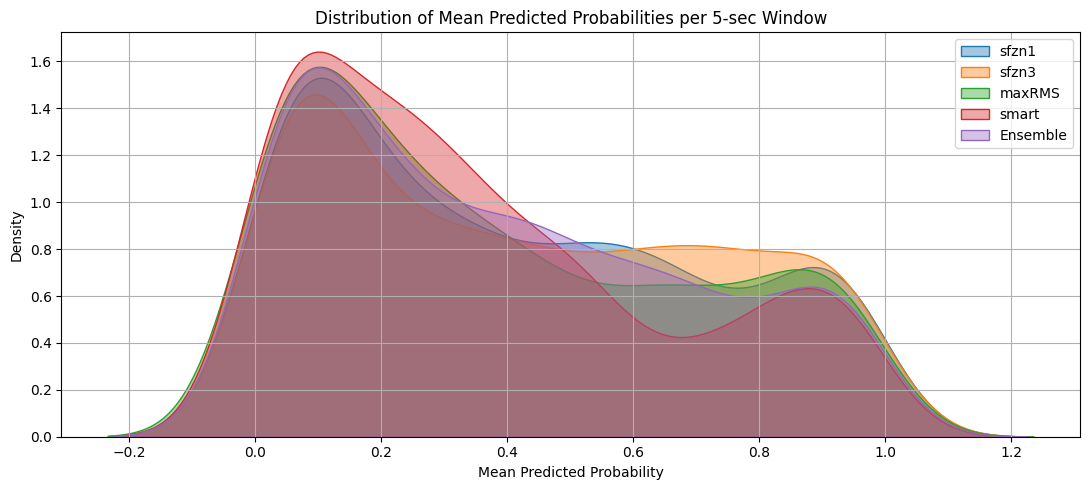

==== Summary Statistics per Model ====


,Model,Mean,Std,Min,Max
0,sfzn1,0.405924,0.303293,0.003668,0.992366
1,sfzn3,0.422009,0.306726,0.004720,0.997157
2,maxRMS,0.386884,0.304478,0.002418,0.998032
3,smart,0.360365,0.290763,0.005727,0.996650
4,Ensemble,0.387937,0.295483,0.004984,0.995677


In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def visualize_model_prediction_distributions(inference_dfs, model_names=None):
    """
    複数モデルのinference出力を可視化する。row_idを除いて平均確率を使う。
    Args:
        inference_dfs (List[pd.DataFrame]): モデルごとの予測データフレーム（row_id含む）
        model_names (List[str], optional): モデル名リスト。未指定なら自動で"Model 1"などに。
    """
    if model_names is None:
        model_names = [f"Model {i+1}" for i in range(len(inference_dfs))]

    plt.figure(figsize=(11, 5))
    stats = []

    for df, name in zip(inference_dfs, model_names):
        # row_id を除いた予測部分だけ抽出
        preds_only = df.drop(columns=["row_id"])
        mean_probs = preds_only.max(axis=1)

        # 分布（KDEプロット）
        sns.kdeplot(mean_probs, label=name, fill=True, alpha=0.4)

        # 統計情報の記録
        stats.append({
            "Model": name,
            "Mean": mean_probs.mean(),
            "Std": mean_probs.std(),
            "Min": mean_probs.min(),
            "Max": mean_probs.max(),
        })

    plt.title("Distribution of Mean Predicted Probabilities per 5-sec Window")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # 統計情報の表示
    stats_df = pd.DataFrame(stats)
    print("==== Summary Statistics per Model ====")
    display(stats_df)
from copy import deepcopy
dfs = deepcopy(inference_dfs)
dfs.append(ensemble_df)
visualize_model_prediction_distributions(dfs, model_names=["sfzn1", "sfzn3", "maxRMS", "smart", "Ensemble"])

In [50]:
len(inference_dfs)

4